In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from scipy.stats import pearsonr
from adjustText import adjust_text

pd.options.display.max_columns = None
RANDOM_SEED = 19991211

In [2]:
vis_data = pd.read_csv("data/visualization_decoy_data_week_9.csv")
games = pd.read_csv('data/games.csv')
player_play = pd.read_csv('data/player_play.csv')
players = pd.read_csv('data/players.csv')
plays = pd.read_csv('data/plays.csv')
tracking_data = pd.read_csv("data/tracking_week_9.csv")

In [3]:
potential_ball_carrier_classifier = XGBClassifier()
potential_ball_carrier_classifier.load_model("models/potential_ball_carrier_predictor.json")

play_type_classifier = XGBClassifier()
play_type_classifier.load_model("models/play_type_predictor.json")

blocker_classifier = XGBClassifier()
blocker_classifier.load_model("models/blocker_predictor.json")

In [4]:
features = [
    'voronoi_area', 'distance_to_qb', 'distance_to_ball', 'defender_influence',
    'teammate_influence', 'defender_awareness', 'teammate_awareness',
    'qb_awareness', 'closest_defender_awareness', 'second_closest_defender_awareness', 
    'closest_teammate_awareness', 'second_closest_teammate_awareness', 
    'closest_defender_distance', 'second_closest_defender_distance', 
    'closest_defender_speed', 'second_closest_defender_speed', 
    'closest_teammate_distance', 'second_closest_teammate_distance', 
    'closest_teammate_speed', 'second_closest_teammate_speed', 'player_speed',
    'relative_x_speed_to_closest_defender', 'relative_x_speed_to_second_closest_defender',
    'relative_y_speed_to_closest_defender', 'relative_y_speed_to_second_closest_defender',
    'relative_x_speed_to_closest_teammate', 'relative_x_speed_to_second_closest_teammate',
    'relative_y_speed_to_closest_teammate', 'relative_y_speed_to_second_closest_teammate', 
    'distance_to_los', 'y_position', 
    ]

ball_carrier_features = ['distance_to_ball', 'distance_to_qb', 'distance_to_los', 'second_closest_teammate_distance', 'closest_defender_distance', 'closest_teammate_distance', 'qb_awareness', 'player_speed', 'y_position', 'teammate_awareness']
blocker_features = ['distance_to_ball', 'distance_to_qb', 'second_closest_teammate_distance', 'closest_teammate_distance', 'distance_to_los', 'qb_awareness', 'y_position', 'second_closest_defender_distance', 'teammate_awareness', 'defender_influence']
play_type_features = ['distance_to_los', 'distance_to_qb', 'defender_influence', 'second_closest_teammate_distance', 'qb_awareness', 'closest_defender_distance', 'distance_to_ball', 'teammate_influence', 'second_closest_defender_distance', 'y_position']

In [5]:
vis_data['ball_carrier_probability'] = potential_ball_carrier_classifier.predict_proba(vis_data[ball_carrier_features])[:, 1]
vis_data['pass_probability'] = play_type_classifier.predict_proba(vis_data[play_type_features])[:, 1]
vis_data['receiver_probability'] = vis_data.apply(lambda x: x.pass_probability * x.ball_carrier_probability, axis = 1)
vis_data['rusher_probability'] = vis_data.apply(lambda x: (1 - x.pass_probability) * x.ball_carrier_probability, axis = 1)
vis_data['blocker_probability'] = blocker_classifier.predict_proba(vis_data[blocker_features])[:, 1]

### Probabilities by Ball Carrier Status

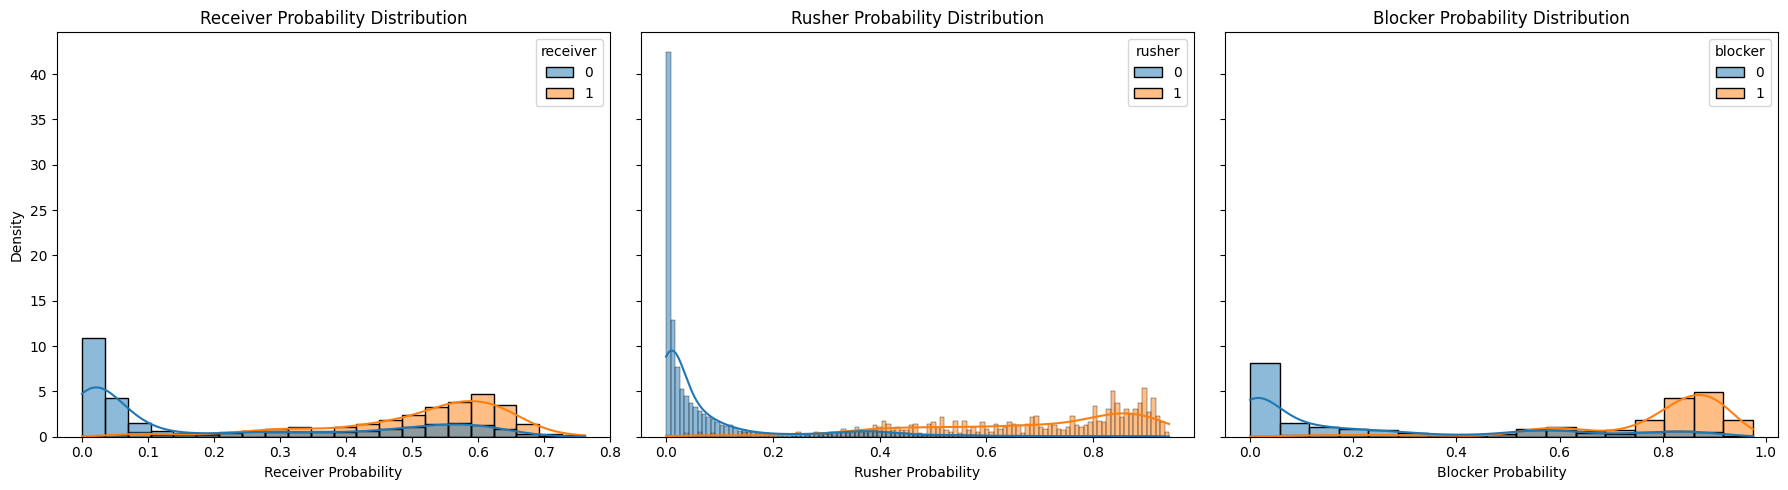

In [6]:
# Group by mean probabilities for players
df = vis_data.groupby(['gameId', 'playId', 'nflId']).mean(numeric_only=True)[
    ['blocker_probability', 'rusher_probability', 'receiver_probability']
].reset_index()

# Merge with relevant datasets
df = df.merge(player_play, on=['gameId', 'playId', 'nflId'], how='inner')
df = df.merge(plays, on=['gameId', 'playId'], how='inner')
df = df.merge(players, on='nflId', how='inner')

# Rank receivers by receiver probability within each play
df['receiver_rank'] = df.groupby(['gameId', 'playId'])['receiver_probability'].rank(method='first', ascending=False)

# Create ballCarrier classification columns
df['receiver'] = df['wasTargettedReceiver'].apply(lambda x: 1 if x == 1 else 0)
df['rusher'] = df['hadRushAttempt'].apply(lambda x: 1 if x == 1 else 0)
df['blocker'] = df.apply(
    lambda x: 1 if x.wasTargettedReceiver == 0 and x.hadRushAttempt == 0 and not np.isnan(x.blockedPlayerNFLId1) else 0, axis=1
)

# Plot histograms for each probability type with KDE
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Receiver histogram
sns.histplot(
    df, x='receiver_probability', hue='receiver', kde=True, stat='density', common_norm=False, ax=axes[0]
)
axes[0].set_title('Receiver Probability Distribution')
axes[0].set_xlabel('Receiver Probability')
axes[0].set_ylabel('Density')

# Rusher histogram
sns.histplot(
    df, x='rusher_probability', hue='rusher', kde=True, stat='density', common_norm=False, ax=axes[1]
)
axes[1].set_title('Rusher Probability Distribution')
axes[1].set_xlabel('Rusher Probability')

# Blocker histogram
sns.histplot(
    df, x='blocker_probability', hue='blocker', kde=True, stat='density', common_norm=False, ax=axes[2]
)
axes[2].set_title('Blocker Probability Distribution')
axes[2].set_xlabel('Blocker Probability')

# Adjust layout
plt.tight_layout()
plt.show()

### Predicting Play Type

C:\Users\Simeel\AppData\Local\Temp\ipykernel_29020\2119120619.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_play_types.loc[:, 'playType'] = actual_play_types.apply(lambda x: "pass" if x.wasTargettedReceiver==1 else "run", axis = 1)


Prediction accuracy: 72.18%


Text(0, 0.5, 'Density')

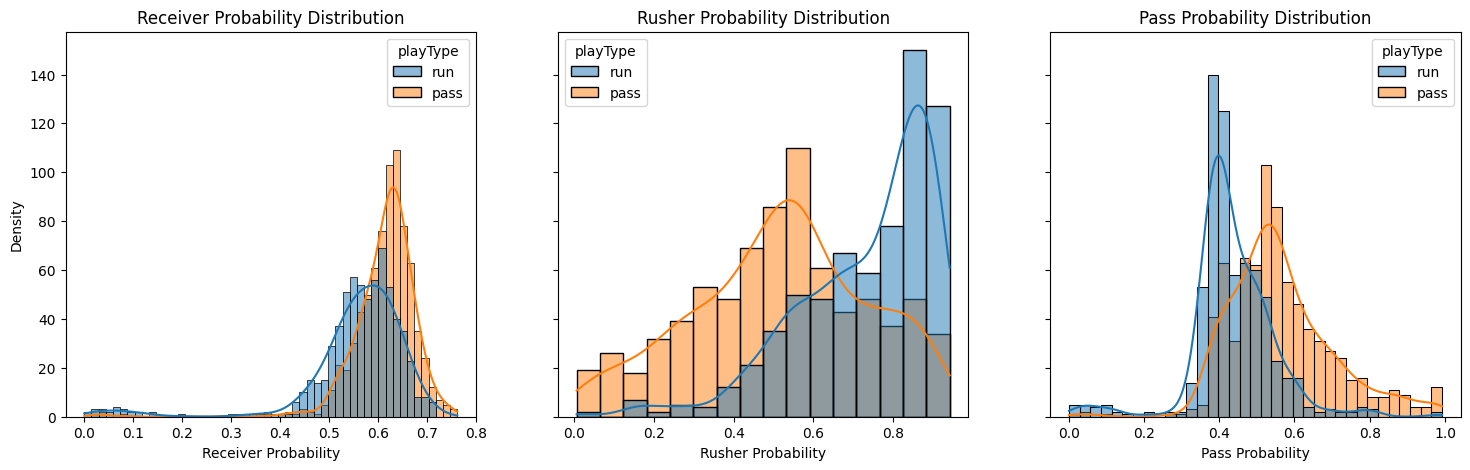

In [7]:
# Calculate mean probabilities per player per play
df = vis_data.groupby(['gameId', 'playId', 'nflId']).mean(numeric_only=True)[
    ['blocker_probability', 'rusher_probability', 'receiver_probability', 'ball_carrier_probability']
].reset_index()

# Merge with additional data
df = df.merge(player_play, on=['gameId', 'playId', 'nflId'], how='inner')
df = df.merge(plays, on=['gameId', 'playId'], how='inner')
df = df.merge(players, on='nflId', how='inner')

# Filter out players
filtered_df = df[(df['blocker_probability'] < 0.75) & (df['ball_carrier_probability'] >= 0.5)]

# Classify play type
play_type_df = filtered_df.groupby(['gameId', 'playId']).agg(
    average_receiver_prob=('receiver_probability', 'max'),
    average_rusher_prob=('rusher_probability', 'max')
).reset_index()

actual_play_types = player_play[(player_play.wasTargettedReceiver==1)|(player_play.hadRushAttempt==1)]
actual_play_types.loc[:, 'playType'] = actual_play_types.apply(lambda x: "pass" if x.wasTargettedReceiver==1 else "run", axis = 1)

# Merge the average weighted pass probability back with the plays data
play_type_df = play_type_df.merge(actual_play_types, on=['gameId', 'playId'], how='inner')

# Classify play type based on weighted pass probability
play_type_df['predicted_play_type'] = play_type_df.apply(
    lambda x: 'pass' if x.average_receiver_prob >= x.average_rusher_prob else 'run', axis = 1
)
play_type_df['pass_probability'] = play_type_df.apply(
    lambda x: (x.average_receiver_prob) / (x.average_receiver_prob + x.average_rusher_prob), axis = 1
)

# Evaluate accuracy
play_type_df['correct_prediction'] = play_type_df.apply(
    lambda x: 1 if x['predicted_play_type'] == x['playType'] else 0, axis=1
)
accuracy = play_type_df['correct_prediction'].mean()
print(f"Prediction accuracy: {accuracy:.2%}")

# Plot histograms for each probability type with KDE
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.histplot(
    play_type_df, x = 'average_receiver_prob', hue = 'playType', kde = True, ax=axes[0]
)
axes[0].set_title('Receiver Probability Distribution')
axes[0].set_xlabel('Receiver Probability')
axes[0].set_ylabel('Density')

sns.histplot(
    play_type_df, x = 'average_rusher_prob', hue = 'playType', kde = True, ax=axes[1]
)
axes[1].set_title('Rusher Probability Distribution')
axes[1].set_xlabel('Rusher Probability')
axes[1].set_ylabel('Density')

sns.histplot(
    play_type_df, x = 'pass_probability', hue = 'playType', kde = True, ax=axes[2]
)
axes[2].set_title('Pass Probability Distribution')
axes[2].set_xlabel('Pass Probability')
axes[2].set_ylabel('Density')

ROC AUC Score: 0.7915983642420036
Brier Score: 0.20594830102933828
--------------------
Brier Score for Negative: 0.20209545527607592
Brier Score for Positive: 0.20928143736841223
--------------------
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       667
           1       0.78      0.68      0.72       771

    accuracy                           0.72      1438
   macro avg       0.73      0.73      0.72      1438
weighted avg       0.73      0.72      0.72      1438

--------------------
Confusion Matrix:


c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(


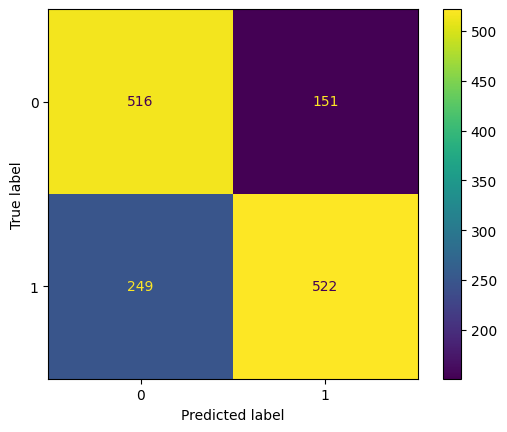

In [8]:
from sklearn.metrics import (ConfusionMatrixDisplay, brier_score_loss,
                             classification_report, confusion_matrix,roc_auc_score)

def score_model(y_true, y_pred, y_prob):
    print(f'ROC AUC Score: {roc_auc_score(y_true=y_true, y_score=y_prob)}')
    print(f"Brier Score: {brier_score_loss(y_true=y_true, y_prob=y_prob)}")
    print('-'*20)
    print(f"Brier Score for Negative: {brier_score_loss(y_true=y_true[y_true==0], y_prob=y_prob[y_true==0])}")
    print(f"Brier Score for Positive: {brier_score_loss(y_true=y_true[y_true==1], y_prob=y_prob[y_true==1])}")
    print('-'*20)
    print(classification_report(y_true=y_true, y_pred=y_pred))
    print('-'*20)
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

score_model(play_type_df.playType.apply(lambda x: 1 if x=='pass' else 0), play_type_df.pass_probability >= 0.5, play_type_df.pass_probability)

### Blocker Probability & Quarterback Protection

Correlation matrix:
                      mean_blocker_prob  mean_blocker_entropy  \
mean_blocker_prob              1.000000             -0.634979   
mean_blocker_entropy          -0.634979              1.000000   
std_blocker_entropy           -0.882534              0.571654   
mean_blocker_flux             -0.252353              0.807539   
std_blocker_flux              -0.366430              0.532267   
mean_blocker_mse              -0.293057              0.686979   
std_blocker_mse               -0.277001              0.623445   
havoc_rate                     0.177518             -0.305239   
expectedPointsAdded           -0.146757              0.261443   
yardsGained                   -0.148457              0.234084   

                      std_blocker_entropy  mean_blocker_flux  \
mean_blocker_prob               -0.882534          -0.252353   
mean_blocker_entropy             0.571654           0.807539   
std_blocker_entropy              1.000000           0.219934   
mean_blo

([Text(0.11007816743641752, 0.3262923776920623, 'ARI'),
  Text(0.14688312485437835, 0.1641025641025641, 'ATL'),
  Text(0.17550148434337481, 0.22775988293315252, 'BAL'),
  Text(0.10871135029934537, 0.36402822674866614, 'BUF'),
  Text(0.11735980624001272, 0.2664072259283216, 'CAR'),
  Text(0.14161564968104545, 0.1487463211596864, 'CHI'),
  Text(0.11697642401777425, 0.17696623213950174, 'CIN'),
  Text(0.14704729433444697, 0.20830649106639548, 'DET'),
  Text(0.12394530219246516, 0.32371947889274855, 'GB'),
  Text(0.1599600893839128, 0.2885565286354586, 'HOU'),
  Text(0.09778459909117738, 0.41291460268075175, 'IND'),
  Text(0.14470611235342334, 0.18492080791173848, 'JAX'),
  Text(0.06520854885038953, 0.3277598829331525, 'KC'),
  Text(0.11714476622387998, 0.29965530776975385, 'LA'),
  Text(0.10535412187437679, 0.2328103879836576, 'LAC'),
  Text(0.0913712610235135, 0.5149716229750813, 'LV'),
  Text(0.128621025588987, 0.2148399862923257, 'MIA'),
  Text(0.10633740732024904, 0.4809474967765041, 

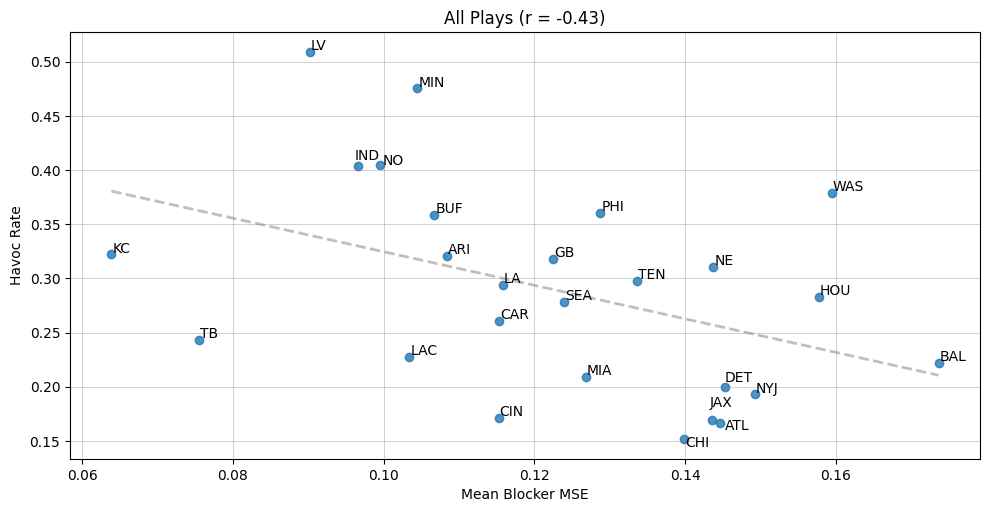

In [9]:
# Compute mean probabilities per player per play
df = vis_data.groupby(['gameId', 'playId', 'nflId']).mean(numeric_only=True)[
    ['blocker_probability', 'rusher_probability', 'receiver_probability', 'ball_carrier_probability', 'isBlocker', 'isRusher', 'isReceiver']
].reset_index()

# Compute probability flux per player per play
probability_flux = vis_data.sort_values(by=['gameId', 'playId', 'nflId', 'frameId']).copy()
probability_flux['blocker_flux'] = probability_flux.groupby(['gameId', 'playId', 'nflId'])['blocker_probability'].diff().abs()

flux_aggregated = probability_flux.groupby(['gameId', 'playId', 'nflId']).mean(numeric_only=True)[
    ['blocker_flux',]
].reset_index()

# Merge probability flux with mean probabilities and other data
df = df.merge(flux_aggregated, on=['gameId', 'playId', 'nflId'], how='inner')
df = df.merge(player_play, on=['gameId', 'playId', 'nflId'], how='inner')
df = df.merge(plays, on=['gameId', 'playId'], how='inner')
df = df.merge(players, on='nflId', how='inner')

# Compute entropies
df.loc[:, 'blocker_entropy'] = df['blocker_probability'].apply(lambda p: - (p * np.log2(p) + (1-p) * np.log2(1-p)))

# Compute MSE
df.loc[:, "blocker_mse"] = df.apply(lambda x: (x.isBlocker - x.blocker_probability)**2, axis = 1)

# Compute Havoc rate for plays
havoc_rate = player_play.copy()
havoc_rate.loc[:, "havoc_rate"] = havoc_rate.apply(lambda x: 1 if x.forcedFumbleAsDefense == 1 or x.passDefensed == 1 or x.halfSackYardsAsDefense < 0 or x.sackYardsAsDefense < 0 or x.tackleForALoss == 1 or x.hadInterception == 1 or x.causedPressure else 0, axis=1)
havoc_rate = havoc_rate.groupby(['gameId', 'playId']).max(numeric_only=True)[['havoc_rate']].reset_index()

# Compute aggregate statistics for remaining players in each play
aggregates = df.groupby(['gameId', 'playId', 'teamAbbr']).agg(
    mean_blocker_prob=('blocker_probability', 'mean'),
    mean_blocker_entropy=('blocker_entropy', 'mean'),
    std_blocker_entropy=('blocker_entropy', 'std'),
    mean_blocker_flux=('blocker_flux', 'mean'),
    std_blocker_flux=('blocker_flux', 'std'),
    mean_blocker_mse=('blocker_mse', 'mean'),
    std_blocker_mse=('blocker_mse', 'std'),
).reset_index()

aggregates = aggregates.merge(havoc_rate, on=['gameId', 'playId'], how='inner')

# Merge with play-level data to bring in play success metrics (e.g., EPA, yards gained)
aggregates = aggregates.merge(plays[['gameId', 'playId', 'expectedPointsAdded', 'yardsGained',]], on=['gameId', 'playId'], how='inner')

columns_to_analyze = [
    'mean_blocker_prob', 
    'mean_blocker_entropy', 'std_blocker_entropy', 
    'mean_blocker_flux', 'std_blocker_flux', 
    'mean_blocker_mse', 'std_blocker_mse',
    'havoc_rate', 'expectedPointsAdded', 'yardsGained',
]

# Aggregate plays by team
aggregates = aggregates.groupby(['teamAbbr']).mean(numeric_only=True)[columns_to_analyze].reset_index()

# Calculate correlations and p-values between aggregate statistics and play success metrics
correlations = pd.DataFrame(index=columns_to_analyze, columns=columns_to_analyze)
p_values = pd.DataFrame(index=columns_to_analyze, columns=columns_to_analyze)

for col1 in columns_to_analyze:
    for col2 in columns_to_analyze:
        if col1 == col2:
            correlations.loc[col1, col2] = 1.0
            p_values.loc[col1, col2] = 0.0
        else:
            # Align the two series to ensure they have the same length and indices
            x, y = aggregates[col1].dropna(), aggregates[col2].dropna()
            x, y = x.align(y, join='inner')
            
            # Compute correlation and p-value
            if len(x) > 1:  # Ensure there are enough data points
                r, p = pearsonr(x, y)
                correlations.loc[col1, col2] = r
                p_values.loc[col1, col2] = p
            else:
                correlations.loc[col1, col2] = np.nan
                p_values.loc[col1, col2] = np.nan

# Convert correlation and p-value DataFrames to numeric
correlations = correlations.astype(float)
p_values = p_values.astype(float)

# Output correlation matrix and p-value matrix
print("Correlation matrix:")
print(correlations)

print("\nP-value matrix:")
print(p_values)

# Create the scatterplot
ax = sns.lmplot(
    x='mean_blocker_mse',  # Horizontal axis
    y='havoc_rate',  # Vertical axis
    data=aggregates,  # Data source
    ci=False,
    fit_reg=True,  # Fit a regression line
    aspect=2,  # Size and dimension
    line_kws={"color": "grey", "linewidth": 2, "linestyle": "--", 'alpha': 0.5}
)

# Add all four edges to the plot
sns.despine(left=False, bottom=False, top=False, right=False)

# Set plot title and labels
plt.title('All Plays (r = -0.43)')
plt.xlabel('Mean Blocker MSE')
plt.ylabel('Havoc Rate')

# Add grey grid lines
plt.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5)

# Add team labels to points
texts = []
for _, row in aggregates.iterrows():
    texts.append(plt.text(row['mean_blocker_mse'], row['havoc_rate'], row['teamAbbr'], fontsize=10, alpha=1, color='black'))

# Adjust text to avoid overlap
adjust_text(texts, ax=plt.gca())

### RB Run Plays

Context: Designed run plays that result in a rush.

RB rusher entropy is negatively correlated with EPA per rush, meaning in run plays RBs who are not well positioned to receive the ball reduce the success of their plays

C:\Users\Simeel\AppData\Local\Temp\ipykernel_29020\365956449.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_players['id'] = regular_players['gameId'].astype(str) + '-' + regular_players['playId'].astype(str)
C:\Users\Simeel\AppData\Local\Temp\ipykernel_29020\365956449.py:56: FutureWarning: The provided callable <function nanmean at 0x000001F3FDF540E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregates = df.groupby(['gameId', 'playId', 'nflId']).agg(


Correlation matrix:
                              nflId  mean_role_entropy  mean_blocker_entropy  \
nflId                      1.000000           0.457095              0.407870   
mean_role_entropy          0.457095           1.000000              0.806497   
mean_blocker_entropy       0.407870           0.806497              1.000000   
mean_rusher_entropy        0.394399           0.947665              0.607862   
mean_receiver_entropy      0.428213           0.939734              0.578661   
mean_ball_carrier_entropy  0.446912           0.909607              0.744321   
mean_role_flux             0.486740           0.918276              0.674464   
mean_blocker_flux          0.333001           0.634427              0.747581   
mean_rusher_flux           0.477040           0.889332              0.559201   
mean_receiver_flux         0.479132           0.910067              0.559143   
mean_blocker_mse           0.272778           0.756440              0.788131   
mean_rusher_mse     

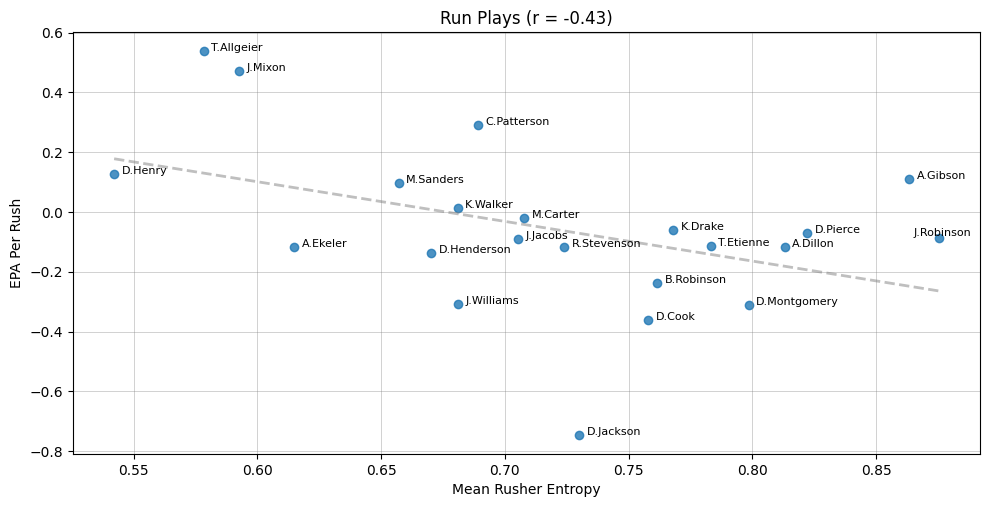

In [124]:
# Compute mean probabilities per player per play
df = vis_data.groupby(['gameId', 'playId', 'nflId']).mean(numeric_only=True)[
    ['blocker_probability', 'rusher_probability', 'receiver_probability', 'ball_carrier_probability', 'isBlocker', 'isRusher', 'isReceiver']
].reset_index()

# Filter to pass plays
# run_plays = player_play[player_play.hadRushAttempt==1].groupby(['gameId', 'playId']).count().reset_index()
# df = df.merge(run_plays[['gameId', 'playId']], on=['gameId', 'playId'], how='inner')

# Compute probability flux per player per play
probability_flux = vis_data.sort_values(by=['gameId', 'playId', 'nflId', 'frameId']).copy()
probability_flux['blocker_flux'] = probability_flux.groupby(['gameId', 'playId', 'nflId'])['blocker_probability'].diff().abs()
probability_flux['rusher_flux'] = probability_flux.groupby(['gameId', 'playId', 'nflId'])['rusher_probability'].diff().abs()
probability_flux['receiver_flux'] = probability_flux.groupby(['gameId', 'playId', 'nflId'])['receiver_probability'].diff().abs()
probability_flux['role_flux'] = probability_flux.apply(lambda x: x.blocker_flux + x.receiver_flux + x.rusher_flux, axis = 1)

flux_aggregated = probability_flux.groupby(['gameId', 'playId', 'nflId']).mean(numeric_only=True)[
    ['blocker_flux', 'rusher_flux', 'receiver_flux', 'role_flux']
].reset_index()

# Merge probability flux with mean probabilities and other data
df = df.merge(flux_aggregated, on=['gameId', 'playId', 'nflId'], how='inner')
df = df.merge(player_play, on=['gameId', 'playId', 'nflId'], how='inner')
df = df.merge(plays[plays.isDropback==False], on=['gameId', 'playId'], how='inner')
df = df.merge(players, on='nflId', how='inner')

# Identify regular players
regular_players = df[(df.position.isin(['RB'])) & (df.hadRushAttempt==1)]
regular_players['id'] = regular_players['gameId'].astype(str) + '-' + regular_players['playId'].astype(str)
regular_players = regular_players.groupby('nflId').nunique()['id'].reset_index().rename(columns={'id': 'num_plays'})
regular_players = regular_players[regular_players.num_plays >= 10][['nflId']]
df = df.merge(regular_players, on='nflId', how='inner')

# Compute entropies
df.loc[:, 'blocker_entropy'] = df['blocker_probability'].apply(lambda p: - (p * np.log2(p) + (1-p) * np.log2(1-p)))
df.loc[:, 'rusher_entropy'] = df['rusher_probability'].apply(lambda p: - (p * np.log2(p) + (1-p) * np.log2(1-p)))
df.loc[:, 'receiver_entropy'] = df['receiver_probability'].apply(lambda p: - (p * np.log2(p) + (1-p) * np.log2(1-p)))
df.loc[:, 'role_entropy'] = df.apply(lambda x: x.blocker_entropy + x.receiver_entropy + x.rusher_entropy, axis=1)
df.loc[:, 'ball_carrier_entropy'] = df['ball_carrier_probability'].apply(lambda p: - (p * np.log2(p) + (1-p) * np.log2(1-p)))

# Compute MSE
df.loc[:, "blocker_mse"] = df.apply(lambda x: (x.isBlocker - x.blocker_probability)**2, axis = 1)
df.loc[:, "rusher_mse"] = df.apply(lambda x: (x.isRusher - x.rusher_probability)**2, axis = 1)
df.loc[:, "receiver_mse"] = df.apply(lambda x: (x.isReceiver - x.receiver_probability)**2, axis = 1)

# Compute EPA and Yards per rush
df.loc[:, 'epa_per_rush'] = df.apply(lambda x: x.expectedPointsAdded if x.hadRushAttempt == 1 else np.nan, axis = 1)
df.loc[:, 'yards_per_rush'] = df.apply(lambda x: x.yardsGained if x.hadRushAttempt == 1 else np.nan, axis = 1)

# Compute Havoc rate for plays
havoc_rate = player_play.copy()
havoc_rate.loc[:, "havoc_rate"] = havoc_rate.apply(lambda x: 1 if x.forcedFumbleAsDefense == 1 or x.passDefensed == 1 or x.halfSackYardsAsDefense < 0 or x.sackYardsAsDefense < 0 or x.tackleForALoss == 1 or x.hadInterception == 1 or x.causedPressure else 0, axis=1)
havoc_rate = havoc_rate.groupby(['gameId', 'playId']).max(numeric_only=True)[['havoc_rate']].reset_index()

# Compute aggregate statistics for remaining players in each play
aggregates = df.groupby(['gameId', 'playId', 'nflId']).agg(
    mean_role_entropy=('role_entropy', 'mean'),
    mean_blocker_entropy=('blocker_entropy', 'mean'),
    mean_rusher_entropy=('rusher_entropy', 'mean'),
    mean_receiver_entropy=('receiver_entropy', 'mean'),
    mean_ball_carrier_entropy=('ball_carrier_entropy', 'mean'),
    mean_role_flux=('role_flux', 'mean'),
    mean_blocker_flux=('blocker_flux', 'mean'),
    mean_rusher_flux=('rusher_flux', 'mean'),
    mean_receiver_flux=('receiver_flux', 'mean'),
    mean_blocker_mse=('blocker_mse', 'mean'),
    mean_rusher_mse=('rusher_mse', 'mean'),
    mean_receiver_mse=('receiver_mse', 'mean'),
    epa_per_rush=('epa_per_rush', np.nanmean),
    yards_per_rush=('yards_per_rush', np.nanmean),
).reset_index()
aggregates = aggregates.merge(havoc_rate, on=['gameId', 'playId'], how='inner')

# Merge with play-level data to bring in play success metrics (e.g., EPA, yards gained)
aggregates = aggregates.merge(plays[['gameId', 'playId', 'expectedPointsAdded', 'yardsGained']], on=['gameId', 'playId'], how='inner')

# Aggregate plays by team
aggregates = aggregates.groupby(['nflId']).mean(numeric_only=True)[
    [
        'mean_role_entropy', 'mean_blocker_entropy', 'mean_rusher_entropy', 'mean_receiver_entropy', 
        'mean_ball_carrier_entropy', 'mean_role_flux', 'mean_blocker_flux', 'mean_rusher_flux', 'mean_receiver_flux', 
        'mean_blocker_mse', 'mean_rusher_mse', 'mean_receiver_mse', 
        'havoc_rate', 'expectedPointsAdded', 'yardsGained', 'epa_per_rush', 'yards_per_rush'
    ]
].reset_index()

# Calculate correlations and p-values between aggregate statistics and play success metrics
columns_to_analyze = aggregates.columns

correlations = pd.DataFrame(index=columns_to_analyze, columns=columns_to_analyze)
p_values = pd.DataFrame(index=columns_to_analyze, columns=columns_to_analyze)

for col1 in columns_to_analyze:
    for col2 in columns_to_analyze:
        if col1 == col2:
            correlations.loc[col1, col2] = 1.0
            p_values.loc[col1, col2] = 0.0
        else:
            # Align the two series to ensure they have the same length and indices
            x, y = aggregates[col1].dropna(), aggregates[col2].dropna()
            x, y = x.align(y, join='inner')
            
            # Compute correlation and p-value
            if len(x) > 1:  # Ensure there are enough data points
                r, p = pearsonr(x, y)
                correlations.loc[col1, col2] = r
                p_values.loc[col1, col2] = p
            else:
                correlations.loc[col1, col2] = np.nan
                p_values.loc[col1, col2] = np.nan

# Convert correlation and p-value DataFrames to numeric
correlations = correlations.astype(float)
p_values = p_values.astype(float)

# Output correlation matrix and p-value matrix
print("Correlation matrix:")
print(correlations)

print("\nP-value matrix:")
print(p_values)

aggregates = aggregates.merge(players, on='nflId', how='inner').sort_values('epa_per_rush', ascending=False)

# Create the scatterplot
ax = sns.lmplot(
    x='mean_rusher_entropy',  # Horizontal axis
    y='epa_per_rush',  # Vertical axis
    data=aggregates,  # Data source
    ci=False,
    fit_reg=True,  # Fit a regression line
    aspect=2,  # Size and dimension
    line_kws={"color": "grey", "linewidth": 2, "linestyle": "--", 'alpha': 0.5}
)

# Add all four edges to the plot
sns.despine(left=False, bottom=False, top=False, right=False)

# Set plot title and labels
plt.title('Run Plays (r = -0.43)')
plt.xlabel('Mean Rusher Entropy')
plt.ylabel('EPA Per Rush')

# Add grey grid lines
plt.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5)

# Add team labels to points
for _, row in aggregates.iterrows():
    if row['displayName'] != 'James Robinson':
        plt.gca().text(row.mean_rusher_entropy+.003, row.epa_per_rush, str(row.displayName).split(' ')[0][0] + "." + str(row.displayName).split(' ')[-1], fontsize=8, alpha = 1, color='black')
    else:
        plt.gca().text(row.mean_rusher_entropy-.01, row.epa_per_rush+0.006, str(row.displayName).split(' ')[0][0] + "." + str(row.displayName).split(' ')[-1], fontsize=8, alpha = 1, color='black')